# T003 · Molecular filtering: unwanted substructures

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Maximilian Driller, CADD seminar, 2017, Charité/FU Berlin
- Sandra Krüger, CADD seminar, 2018, Charité/FU Berlin

__Talktorial T003__: This talktorial is part of the TeachOpenCADD pipeline described in the first TeachOpenCADD publication ([_J. Cheminform._ (2019), **11**, 1-7](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x)), comprising of talktorials T001-T010.

## Aim of this talktorial

There are some substructures we prefer not to include into our screening library. In this talktorial, we learn about different types of such unwanted substructures and how to find, highlight and remove them with RDKit.

### Contents in Theory

* Unwanted substructures
* Pan Assay Interference Compounds (PAINS)  

### Contents in Practical

* Load and visualize data
* Filter for PAINS
* Filter for unwanted substructures
* Highlight substructures
* Substructure statistics

### References

* Pan Assay Interference compounds ([wikipedia](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds), [_J. Med. Chem._ (2010), **53**, 2719-2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)) 
* Unwanted substructures according to Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 435-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139))
* Inspired by a Teach-Discover-Treat tutorial ([repository](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb))
* RDKit ([repository](https://github.com/rdkit/rdkit), [documentation](https://www.rdkit.org/docs/index.html))

## Theory

### Unwanted substructures

Substructures can be unfavorable, e.g., because they are toxic or reactive, due to unfavorable pharmacokinetic properties, or because they likely interfere with certain assays.
Nowadays, drug discovery campaigns often involve [high throughput screening](https://en.wikipedia.org/wiki/High-throughput_screening). Filtering unwanted substructures can support assembling more efficient screening libraries, which can save time and resources. 

Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 435-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)) have assembled a list of unfavorable substructures to filter their libraries used to screen for compounds to treat neglected diseases. Examples of such unwanted features are nitro groups (mutagenic), sulfates and phosphates (likely resulting in unfavorable pharmacokinetic properties), 2-halopyridines and thiols (reactive). This list of undesired substructures was published in the above mentioned paper and will be used in the practical part of this talktorial.

### Pan Assay Interference Compounds (PAINS)

[PAINS](https://en.wikipedia.org/wiki/Pan-assay_interference_compounds) are compounds that often occur as hits in HTS even though they actually are false positives. PAINS show activity at numerous targets rather than one specific target. Such behavior results from unspecific binding or interaction with assay components. Baell *et al.* ([_J. Med. Chem._ (2010), **53**, 2719-2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)) focused on substructures interfering in assay signaling. They described substructures which can help to identify such PAINS and provided a list which can be used for substructure filtering.

![PAINS](images/PAINS_Figure.jpeg)

Figure 1: Specific and unspecific binding in the context of PAINS. Figure taken from [Wikipedia](https://commons.wikimedia.org/wiki/File:PAINS_Figure.tif).

## Practical

### Load and visualize data

First, we import the required libraries, load our filtered dataset from **Talktorial T002** and draw the first molecules.

In [1]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

import mols2grid

In [2]:
# define paths
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
# load data from Talktorial T2
egfr_data = pd.read_csv(
    HERE / "../T002_compound_adme/data/EGFR_compounds_lipinski.csv",
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
egfr_data.head()

Dataframe shape: (4635, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True


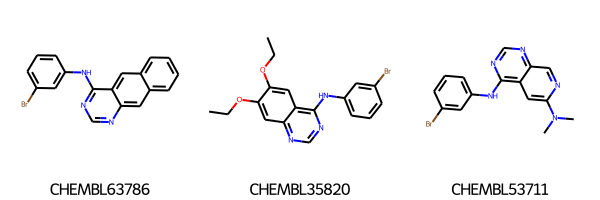

In [4]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(egfr_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(egfr_data.head(3).ROMol),
    legends=list(egfr_data.head(3).molecule_chembl_id),
)

### Filter for PAINS

The PAINS filter is already implemented in RDKit ([documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html)). Such pre-defined filters can be applied via the `FilterCatalog` class. Let's learn how it can be used.

In [5]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [6]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/4635 [00:00<?, ?it/s]

In [7]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")

Number of compounds with PAINS: 408
Number of compounds without PAINS: 4227


Let's have a look at the first 3 identified PAINS.

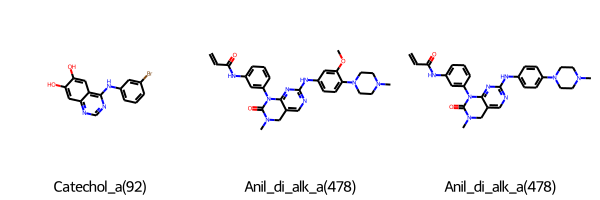

In [8]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

### Filter and highlight unwanted substructures

Some lists of unwanted substructures, like PAINS, are already implemented in RDKit. However, it is also possible to use an external list and get the substructure matches manually. 
Here, we use the list provided in the supporting information from Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 535-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)).

In [9]:
substructures = pd.read_csv(DATA / "unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 104


Let's have a look at a few substructures.

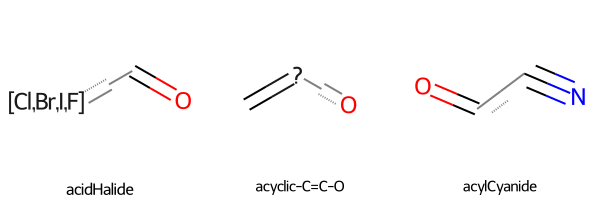

In [10]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

Search our filtered dataframe for matches with these unwanted substructures.

In [11]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]

  0%|          | 0/4227 [00:00<?, ?it/s]

In [12]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(egfr_data)}")

Number of found unwanted substructure: 3232
Number of compounds without unwanted substructure: 2089


### Highlight substructures

Let's have a look at the first 3 identified unwanted substructures. Since we have access to the underlying SMARTS patterns we can highlight the substructures within the RDKit molecules.

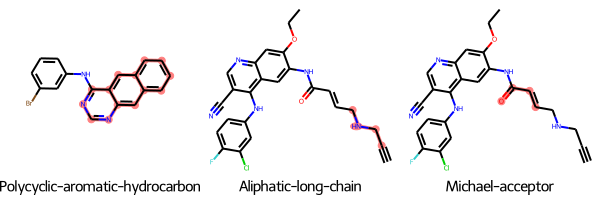

In [13]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

The `mols2grid` package provides an enhanced visualization of Dataframes containing molecules. 
It's possible to visualize a subset of the dataset matching specific unwanted substructures let's have a look at the molecules matching the following filters:
- _three-memeber-heterociclics_ `*1[O,S,N]*1`
- _aliphatic-long-chains_ `[R0&D2][R0&D2][R0&D2][R0&D2]`
- _alkyl-halide_ `[CX4][Cl,Br,I]`


Procedure:
1. Select SMARTS in the search box
2. Copy and paste each one of the SMARTS patterns listed above.

In [14]:
mols2grid.display(matches.iloc[:100], 
                # specify the column containing the ROMol objects
                mol_col = 'rdkit_molecule',
                # specify the column containg the SMILES to generate the ROMol is not available
                smi_col = None,
                # set what's displayed on the grid
                subset = ["img","chembl_id"],
                # set what's displayed on the hover tooltip
                tooltip = ["substructure_name"],
                # number of rows and columns per page
                n_cols=4, n_rows=3,
                # image size
                size=(200, 120),
)

### Substructure statistics

Finally, we want to find the most frequent substructure found in our data set. The Pandas `DataFrame` provides convenient methods to group containing data and to retrieve group sizes.

In [15]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
Michael-acceptor               1113
Aliphatic-long-chain            489
Oxygen-nitrogen-single-bond     367
triple-bond                     252
nitro-group                     177
imine                           150
Thiocarbonyl-group              114
aniline                          64
halogenated-ring                 62
conjugated-nitrile-group         59
dtype: int64

## Discussion
In this talktorial we learned two possibilities to perform a search for unwanted substructures with RDKit: 

* The `FilterCatalog` class can be used to search for predefined collections of substructures, e.g., PAINS.
* The `HasSubstructMatch()` function to perform manual substructure searches.

Actually, PAINS filtering could also be implemented via manual substructure searches with `HasSubstructMatch()`. Furthermore, the substructures defined by Brenk *et al.* ([_Chem. Med. Chem._ (2008), **3**, 535-44](https://onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)) are already implemented as a `FilterCatalog`. Additional pre-defined collections can be found in the RDKit [documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html). 

So far, we have been using the `HasSubstructMatch()` function, which only yields one match per compound. With the `GetSubstructMatches()` function ([documentation](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html)) we have the opportunity to identify all occurrences of a particular substructure in a compound.
In case of PAINS, we have only looked at the first match per molecule (`GetFirstMatch()`). If we simply want to filter out all PAINS this is enough. However, we could also use `GetMatches()` in order to see all critical substructures of a molecule.

Detected substructures can be handled in two different fashions: 

* Either, the substructure search is applied as a filter and the compounds are excluded from further testing to save time and money. 
* Or, they can be used as warnings, since ~5 % of FDA-approved drugs were found to contain PAINS ([_ACS. Chem. Biol._ (2018), **13**, 36-44](https://pubs.acs.org/doi/10.1021/acschembio.7b00903)). In this case experts can judge manually, if an identified substructure is critical or not.

## Quiz
* Why should we consider removing "PAINS" from a screening library? What is the issue with these compounds?
* Can you find situations when some unwanted substructures would not need to be removed?
* How are the substructures we used in this tutorial encoded?